# Kann mithilfe einer NLP-unterstützten Methodik festgestellt werden ob ein Amazon Review Positiv, Neutral oder Negativ ist, bzw. kann das angegebene Voting errechnet werden?

- Michael Hermann-Hubler
- Michael Kranl

The used data was created by J. Ni, J. Li, and J. McAuley for „Justifying Recommendations using Distantly-Labeled Reviews and Fine-Grained Aspects“, in Proceedings of the 2019 Conference on mpirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP), Hong Kong, China, 2019, S. 188–197. doi: 10.18653/v1/D19-1018. 

## Imports

In [ ]:
import sys
!{sys.executable} -m pip install gzinfo
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install wordcloud

In [1]:
# Pandas
import pandas as pd

# Download
import urllib.request
import glob
import gzip
import gzinfo
import os
import shutil

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Preprocessing
from keras_preprocessing.text import text_to_word_sequence
import nltk
nltk.download('omw-1.4');
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import re

# Feature Representation
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Load Dataset

### Download Sub Dataset

In [2]:
subdatasets = [
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Arts_Crafts_and_Sewing_5.json.gz',
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Industrial_and_Scientific_5.json.gz',
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Luxury_Beauty_5.json.gz',
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Musical_Instruments_5.json.gz'
              ]

def download(x: str):
    urllib.request.urlretrieve(x, '.data/dummy.gz')

    filename = gzinfo.read_gz_info('.data/dummy.gz').fname
    with gzip.open('.data/dummy.gz', 'rb') as f_in:
        with open('.data/' + filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            
    os.remove('.data/dummy.gz')

# only run once as this can take a very long time
if len(os.listdir('.data') ) == 0:
    [download(x) for x in subdatasets]


## Load data

In [3]:
all_files = glob.glob('.data/*')
li = []

for filename in all_files:
    temp_df = pd.read_json(filename, lines=True)
    li.append(temp_df)

df = pd.concat(li, axis=0, ignore_index=True)

## Data Exploration I

In [4]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,True,"03 29, 2016",AIE8N9U317ZBM,0449819906,{'Format:': ' Kindle Edition'},"Zelmira, Ph.D.",Contains some interesting stitches.,Four Stars,1459209600,NaN,NaN
1,5,True,"08 12, 2015",A3ECOW0TWLH9V6,0449819906,{'Format:': ' Paperback'},Dangerous when Cooking,I'm a fairly experienced knitter of the one-co...,My current favorite go-to guide for inspiration,1439337600,18,NaN
2,4,True,"04 5, 2015",A278N8QX9TY2OS,0449819906,{'Format:': ' Paperback'},Just us,Great book but the index is terrible. Had to w...,"lots of great examples, good instructions, col...",1428192000,3,NaN
3,5,True,"10 11, 2014",A123W8HIK76XCN,0449819906,{'Format:': ' Kindle Edition'},Amazon Customer,I purchased the Kindle edition which is incred...,Another little gem by Melissa Leapman,1412985600,NaN,NaN
4,5,True,"05 8, 2014",A2A6MZ2QB4AE0L,0449819906,{'Format:': ' Paperback'},Sustainability,Very well laid out and very easy to read.\n\nT...,Very comprehensive,1399507200,NaN,NaN


In [5]:
df.describe()

,overall,unixReviewTime
count,837226.000000,8.372260e+05
mean,4.524777,1.446987e+09
std,0.953090,4.959673e+07
min,1.000000,1.051402e+09
25%,4.000000,1.418429e+09
50%,5.000000,1.452470e+09
75%,5.000000,1.483402e+09
max,5.000000,1.538525e+09


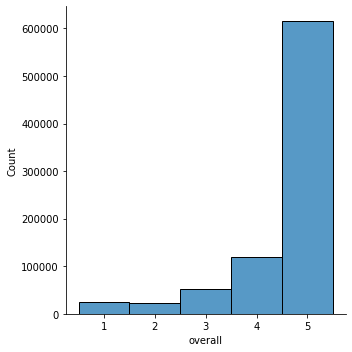

In [6]:
sns.displot(df.overall, discrete=True)

In [7]:
df.groupby('overall').count().reviewText

overall
1     25394
2     23489
3     52973
4    119795
5    615214
Name: reviewText, dtype: int64

The high average overall score means, that we have to split the data differently as we have no normal distibution.

In [8]:
print('Length whole Dataset:', len(df.reviewText))
print('Length Dataset without NA:', len(df.reviewText.dropna()))

Length whole Dataset: 837226
Length Dataset without NA: 836865


There exists missing Data

## Data Cleaning

### Remove unnessesary columns

In [9]:
df = df[['overall', 'reviewText']]

### Remove missing data

In [10]:
df = df.dropna()

### Reduce data to a representative subset
To reduce the data we take random 20.000 samples from each class, without replacement

In [11]:
sampling_size = 20000

li = [
    df[df.overall == 1].sample(sampling_size),
    df[df.overall == 2].sample(sampling_size),
    df[df.overall == 3].sample(sampling_size),
    df[df.overall == 4].sample(sampling_size),
    df[df.overall == 5].sample(sampling_size)
]

df_cleaned = pd.concat(li, axis=0, ignore_index=True)

In [12]:
df_cleaned.describe()

,overall
count,100000.000000
mean,3.000000
std,1.414221
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [13]:
df_cleaned.head()

,overall,reviewText
0,1,"Shattered in package, parts missing. Save the ..."
1,1,I bought this a year or two ago. Thank you
2,1,"Returned one that didn't function, got a repla..."
3,1,I have been working with clay professionally f...
4,1,I do not like this brand of erasers.\n They ge...


## Preprocessing

### Lowercasing

In [14]:
df_lowercase = df_cleaned.copy()
df_lowercase.reviewText = df_lowercase.reviewText.str.lower()
df_lowercase.head()

,overall,reviewText
0,1,"shattered in package, parts missing. save the ..."
1,1,i bought this a year or two ago. thank you
2,1,"returned one that didn't function, got a repla..."
3,1,i have been working with clay professionally f...
4,1,i do not like this brand of erasers.\n they ge...


### Remove Special Chars

In [15]:
regex = '[^ A-Za-z.,?!\\\\]+'

df_spec_cars_removed = df_lowercase.copy()
df_spec_cars_removed.reviewText = df_spec_cars_removed.apply(lambda row: re.sub(regex, '', row.reviewText), axis=1)
df_spec_cars_removed.head()

,overall,reviewText
0,1,"shattered in package, parts missing. save the ..."
1,1,i bought this a year or two ago. thank you
2,1,"returned one that didnt function, got a replac..."
3,1,i have been working with clay professionally f...
4,1,i do not like this brand of erasers. they get ...


### Tokenization

In [16]:
df_token = df_spec_cars_removed.copy()
df_token.reviewText = df_token.apply(lambda row: text_to_word_sequence(row.reviewText), axis=1)
df_token.head()

,overall,reviewText
0,1,"[shattered, in, package, parts, missing, save,..."
1,1,"[i, bought, this, a, year, or, two, ago, thank..."
2,1,"[returned, one, that, didnt, function, got, a,..."
3,1,"[i, have, been, working, with, clay, professio..."
4,1,"[i, do, not, like, this, brand, of, erasers, t..."


### Lemmatization 

In [17]:
lemmatizer = WordNetLemmatizer()

df_lemm = df_token.copy()
df_lemm.reviewText = df_lemm.apply(lambda row: [lemmatizer.lemmatize(x) for x in row.reviewText], axis=1)
df_lemm.head()

,overall,reviewText
0,1,"[shattered, in, package, part, missing, save, ..."
1,1,"[i, bought, this, a, year, or, two, ago, thank..."
2,1,"[returned, one, that, didnt, function, got, a,..."
3,1,"[i, have, been, working, with, clay, professio..."
4,1,"[i, do, not, like, this, brand, of, eraser, th..."


### Stemming

Stemming ist used additionally to lemtization, because time forms were not normalized

In [18]:
stemmer = PorterStemmer()

df_stemm = df_lemm.copy()
df_stemm.reviewText = df_stemm.apply(lambda row: [stemmer.stem(x) for x in row.reviewText], axis=1)
df_stemm.head()

,overall,reviewText
0,1,"[shatter, in, packag, part, miss, save, the, m..."
1,1,"[i, bought, thi, a, year, or, two, ago, thank,..."
2,1,"[return, one, that, didnt, function, got, a, r..."
3,1,"[i, have, been, work, with, clay, profession, ..."
4,1,"[i, do, not, like, thi, brand, of, eras, they,..."


### Stopword removal

In [19]:
stopwords_en = stopwords.words('english')

df_removed_stopwords = df_stemm.copy()
df_removed_stopwords.reviewText = df_removed_stopwords.apply(lambda row: [x for x in row.reviewText if x not in stopwords_en and x not in ['\n', '\r']], axis=1)
df_removed_stopwords.head()

,overall,reviewText
0,1,"[shatter, packag, part, miss, save, money, wou..."
1,1,"[bought, thi, year, two, ago, thank]"
2,1,"[return, one, didnt, function, got, replac, re..."
3,1,"[work, clay, profession, year, use, thi, onc, ..."
4,1,"[like, thi, brand, eras, get, buildup, much, b..."


### Define final

In [20]:
df_final = df_removed_stopwords[df_removed_stopwords.reviewText.map(lambda d: len(d)) > 0]
df_final

,overall,reviewText
0,1,"[shatter, packag, part, miss, save, money, wou..."
1,1,"[bought, thi, year, two, ago, thank]"
2,1,"[return, one, didnt, function, got, replac, re..."
3,1,"[work, clay, profession, year, use, thi, onc, ..."
4,1,"[like, thi, brand, eras, get, buildup, much, b..."
...,...,...
99995,5,"[thi, fourth, tc, toneprint, pedal, also, vort..."
99996,5,"[gener, use, domin, zyex, helicor, fiddl, im, ..."
99997,5,"[base, custom, review, thought, tri, thi, appl..."
99998,5,"[beauti, watercolor, small, amount, thi, highl..."


## Data Exploration II

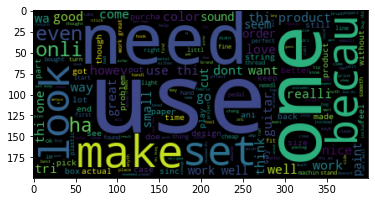

In [21]:
word_list = df_final.reviewText.tolist()
word_list = [i for j in word_list for i in j]

word_list_text = ' '.join(word_list)

wordcloud = WordCloud().generate(word_list_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

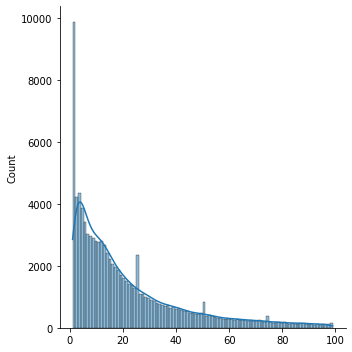

In [22]:
word_counts = [df_final.reviewText.apply(len)][0]
word_counts = [x for x in word_counts if x < 100]

sns.displot(word_counts, kde=True)

In [23]:
[x for x in df_final.reviewText if len(x) < 5][:10]


[['person', 'differ', 'pic'],
 ['ok', 'best'],
 ['sent', 'back'],
 ['expens', 'hollow', 'box', 'buy'],
 ['arriv', 'piec', 'useabl'],
 ['right'],
 ['pictur', 'color', 'represent', 'way'],
 ['wow', 'brush', 'suck'],
 ['orang', 'yellow', 'veri', 'disappoint'],
 ['arriv', 'tarnish']]

These results with just one word seem plausible, thus they will be included

## Feature Representation

### n-Gram

In [24]:
n = 3
ngram = ngrams(df_final.reviewText, n)

df_ngram = df_final.copy()
df_ngram['ngram'] = df_ngram.reviewText

df_ngram.loc[df_ngram.reviewText.apply(len) >= n, 'ngram'] = [list(ngrams(x, n)) for x in df_ngram.reviewText if len(x) >= n]

df_ngram

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,overall,reviewText,ngram
0,1,"[shatter, packag, part, miss, save, money, wou...","[(shatter, packag, part), (packag, part, miss)..."
1,1,"[bought, thi, year, two, ago, thank]","[(bought, thi, year), (thi, year, two), (year,..."
2,1,"[return, one, didnt, function, got, replac, re...","[(return, one, didnt), (one, didnt, function),..."
3,1,"[work, clay, profession, year, use, thi, onc, ...","[(work, clay, profession), (clay, profession, ..."
4,1,"[like, thi, brand, eras, get, buildup, much, b...","[(like, thi, brand), (thi, brand, eras), (bran..."
...,...,...,...
99995,5,"[thi, fourth, tc, toneprint, pedal, also, vort...","[(thi, fourth, tc), (fourth, tc, toneprint), (..."
99996,5,"[gener, use, domin, zyex, helicor, fiddl, im, ...","[(gener, use, domin), (use, domin, zyex), (dom..."
99997,5,"[base, custom, review, thought, tri, thi, appl...","[(base, custom, review), (custom, review, thou..."
99998,5,"[beauti, watercolor, small, amount, thi, highl...","[(beauti, watercolor, small), (watercolor, sma..."


### TF-IDF

In [31]:
v = TfidfVectorizer(stop_words='english', strip_accents='ascii')
v.fit(df_cleaned['reviewText'])

v.vocabulary_

{'shattered': 40275,
 'package': 32411,
 'parts': 32757,
 'missing': 29313,
 'save': 39234,
 'money': 29621,
 'stars': 42775,
 'possible': 34514,
 'bought': 8469,
 'year': 50428,
 'ago': 4050,
 'thank': 45020,
 'returned': 37974,
 'didn': 14593,
 'function': 20023,
 'got': 21052,
 'replacement': 37507,
 'changed': 10231,
 'tone': 45776,
 'significantly': 40693,
 'bass': 7163,
 'guitar': 21611,
 'recommend': 36787,
 'unless': 47445,
 'want': 48939,
 'whacky': 49375,
 'sound': 41888,
 'working': 49975,
 'clay': 10895,
 'professionally': 35220,
 'years': 50433,
 'used': 47927,
 'worked': 49964,
 'great': 21288,
 'tried': 46315,
 'won': 49847,
 'unwind': 47767,
 'make': 27913,
 'space': 41982,
 'new': 30625,
 'flimsy': 19160,
 'piece': 33629,
 'garbage': 20289,
 'like': 26895,
 'brand': 8599,
 'erasers': 17347,
 'buildup': 8999,
 'brands': 8605,
 'harder': 22010,
 'clean': 10904,
 'good': 20980,
 'thing': 45190,
 'inexpensive': 24062,
 'threw': 45331,
 'away': 5828,
 'love': 27416,
 'quali